In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, print_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate_counterfactual_fidelity
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering
from tasks.running_example import make_task
shap.initjs()

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

In [3]:
xlim = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
ylim = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [5]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [7]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='labels')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 4.23 s, sys: 70.8 ms, total: 4.3 s
Wall time: 4.35 s


In [9]:
%%time
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='labels')
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 482 ms, sys: 6.68 ms, total: 489 ms
Wall time: 496 ms


# Traditional SHAP Explanations

In [10]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [11]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

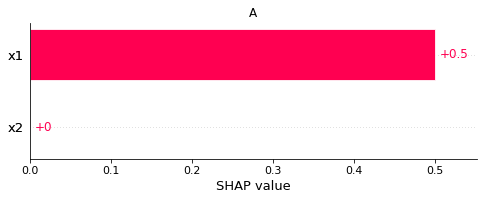

In [12]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

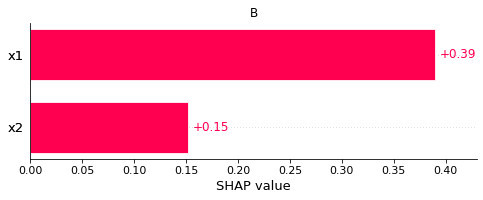

In [13]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [14]:
%%time
node = make_clustering(comparer, indiv_shap_values, feature_precisions=feature_precisions)

CPU times: user 17.5 ms, sys: 2.21 ms, total: 19.7 ms
Wall time: 21.7 ms


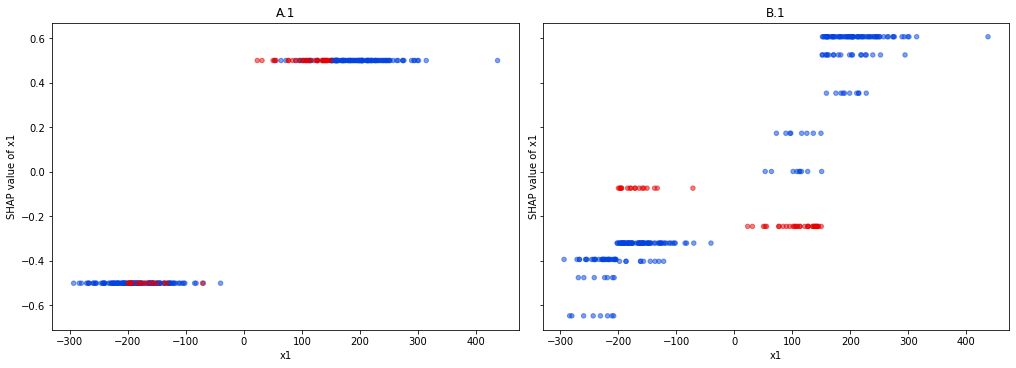

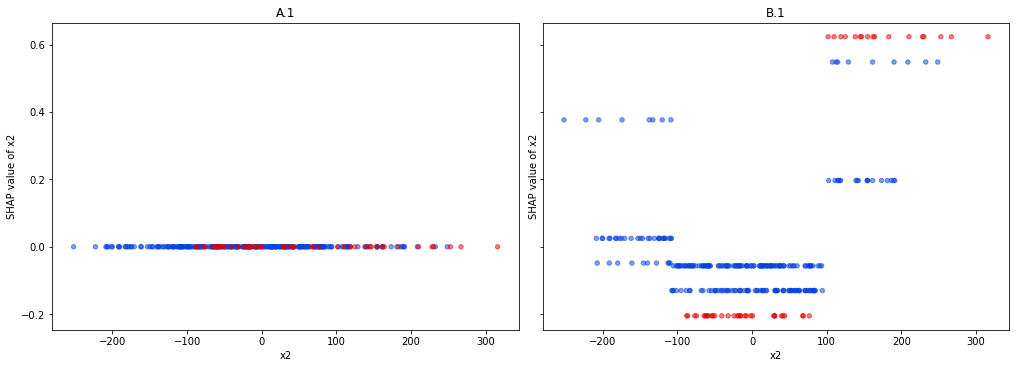

In [15]:
for feature in feature_names:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [5]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

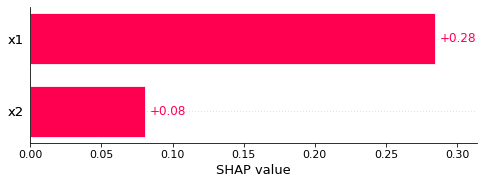

In [6]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

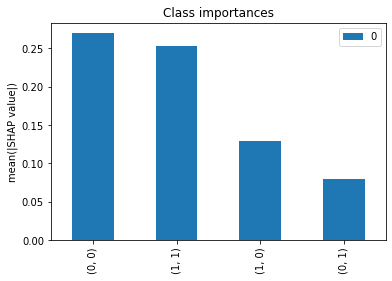

In [7]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

Next, I will have a look at each difference class separately, and interpret it in contrast to the equality classes $(0,0)$ and $(1,1)$. This is an incomplete comparison, because in order for it to be complete, I would need to add the other difference class to the comparison classes. I'm leaving this one out as it is my goal to keep the explanations selected.

## Clustering of Class $(0,1)$ SHAP Values

In [8]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 257 ms, sys: 6.35 ms, total: 263 ms
Wall time: 273 ms


((0, 0)    133
 (1, 1)    118
 (1, 0)     32
 (0, 1)     17
 dtype: int64,
 2.637883333333333)

In [9]:
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

The dendrogram shows the clustering hierarchy. In this case it is simple.

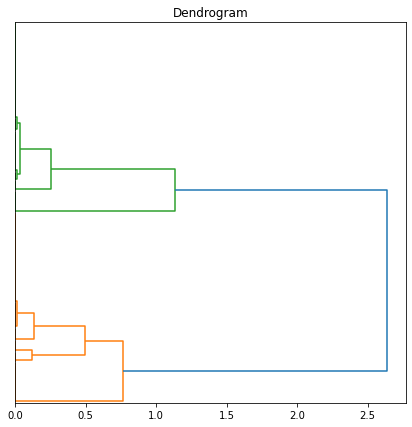

In [10]:
node.plot_dendrogram()

Next I will create dependence plots for each feature. For each feature, there is one plot for the difference class (middle) and one plot each for the equality classes (left and right). Since the dependence plot shows for each instance, what it's SHAP value is in relation to its feature value, we an interpret what the relation between the input and output might be. The instances are colored by their actual label: those classified as the current difference class in red, others in blue.

Additionally, I print the following information to get a better understanding:
- Feature value range of instances classified as the current difference class
- Group counterfactuals

The group counterfactuals are also visualized in the dependence plot via a vertical dashed line.

For $x_1$, there is a lower counterfactual of -203.8, where all instances classified as the current difference class flip their prediction to $(0,0)$, and an upper counterfactual of -8.5, where they flip to $(1,1)$. Looking at the dependence plots, I can interpret the following effects of this feature:
- For values below the lower counterfactual, the SHAP values of $(0,0)$ are in a global high, while both the SHAP values of $(0,1)$ and $(1,1)$ are in a global low.
- For values between the lower counterfactual and the upper counterfactual, the SHAP values of $(1,1)$ are in a global low, while those of $(0,1)$ are in a global high and those of $(0,0)$ in the mid-range. Further, this range includes both instances classified as the current difference class (colored red) and other instances (colored blue). There is a vertical spread between these groups, that results from interactions with other features. Two instances with the same $x_1$ value might have a different SHAP value for this feature, when they have different values in other features. The instances in red have higher SHAP values for $(0,1)$ but lower for $(1,1)$ compared to those in blue. This leads to the conclusion, that there have to be certain values of $x_2$ that lead to them having bigger SHAP values in $(0,1)$ and at the same time lower SHAP values in $(0,0)$.
- For values above the upper counterfactual, both $(0,0)$ and $(0,1)$ are at their lowest, but $(1,1)$ is highest, with different levels present.

If the feature values of the instances classified $(0,1)$ would be decreased, I would expect the $(0,1)$ SHAP values to decrease abruptly and those of $(0,0)$ to increase abruptly at a certain point, possibly flipping the prediction to $(0,0)$. The lower CF supports this theory, because all of them actually flip to $(0,0)$ at -203.8. The same is true vice versa for $(1,1)$ if x1 would be increased to the upper CF at -8.5.

-199.69916519629095 <= x1 <= -71.25341441967325
[Lower CF: x1 == -203.8 --> {'(0, 0)': 17},
 Upper CF: x1 == -8.5 --> {'(1, 1)': 17}]


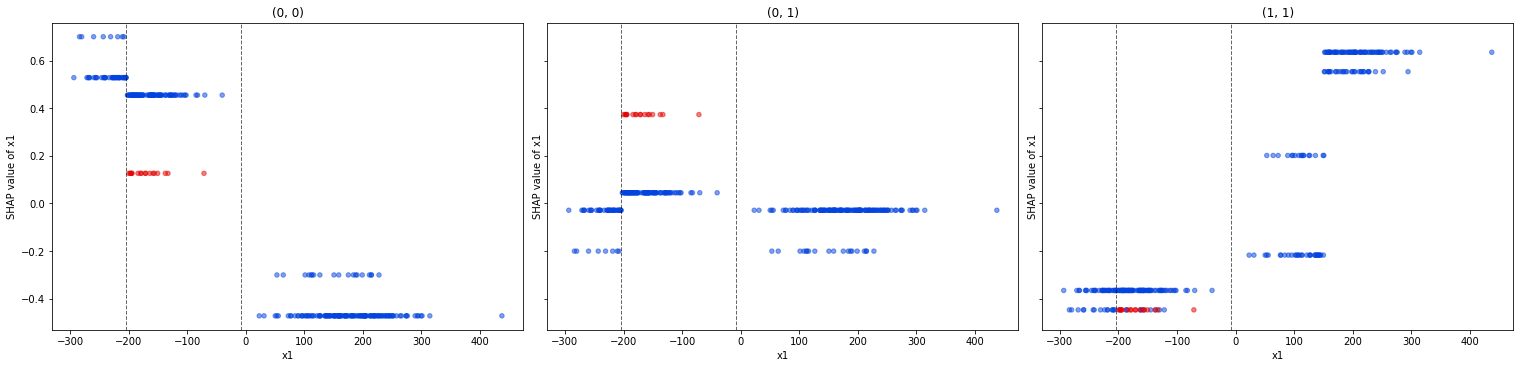

In [11]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.plot_feature_dependence(feature, alpha=0.5)

For $x_2$ there exists only a lower counterfactual at 97.5. Using the dependence plots I can interpret:
- Below approx. -100, $(1,1)$ is in a global high, while both $(0,0)$ and $(0,1)$ are in a global low.
- Further above up to the lower counterfactual, $(0,0)$ is in a global high and both $(0,1)$ and $(1,1)$ are in a global low.
- Above the lower counterfactual, $(0,1)$ and $(1,1)$ are in a global high. In $(0,1)$, the red instances have higher SHAP values than the blue, but in $(1,1)$ it is not so clear, because red instances are mixed with blue instances.

101.87170468931079 <= x2
[Lower CF: x2 == 97.5 --> {'(0, 0)': 17}]


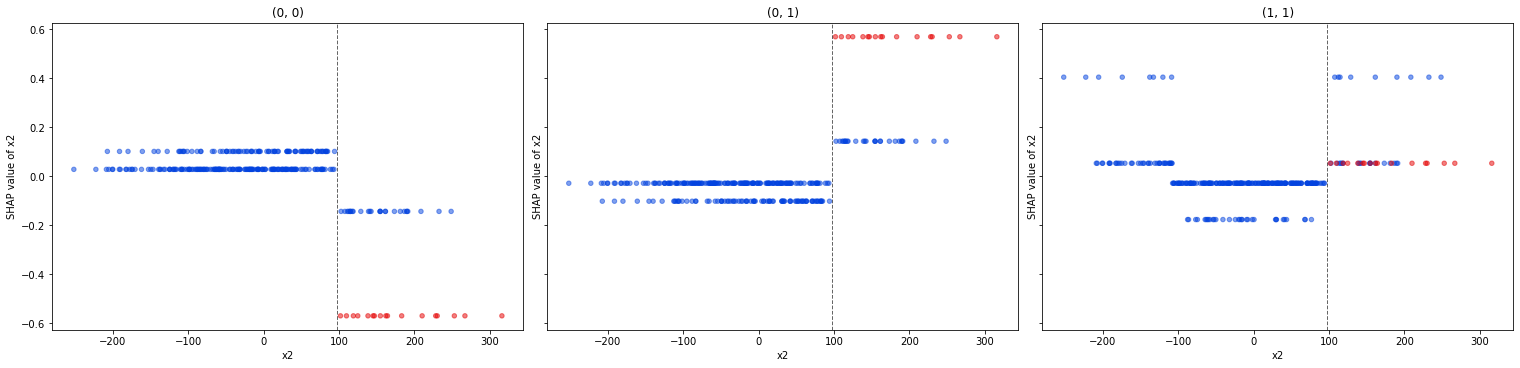

In [12]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.plot_feature_dependence(feature, alpha=0.5)

Based on the knowledge that obtained so far I can reason, that instances with the following rule are likely to be classified as $(0,1)$. The rule, evaluated on the data set achieves perfect performance.

-203.8 < x1 <= -8.6 and x2 > 97.5
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       283
        True       1.00      1.00      1.00        17

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



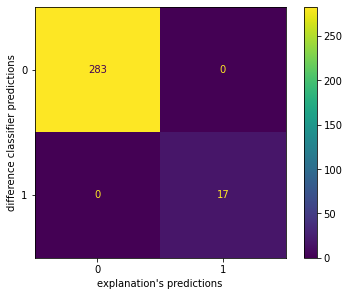

In [14]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [15]:
explanations_global = [(rule, constraint, instance_indices)]

Having analyzed the global explanations, I will now check the next levels of the cluster hierarchy.

### Node L

The left child node doesn't contain instances classified $(0,1)$, so I can skip analyzing it.

In [16]:
node = node.get_left()
node, node.class_counts, node.distance

(L,
 (1, 1)    118
 (1, 0)     32
 dtype: int64,
 0.7636777777777777)

### Node R

The right child node of the root node contains all instances classified $(0,1)$, along with all instances classified $(0,0)$. It's cluster node distance, which measures the heterogeneity within the cluster, is now lower than the parent's.

In [17]:
node = node.parent.get_right()
node, node.class_counts, node.distance

(R,
 (0, 0)    133
 (0, 1)     17
 dtype: int64,
 1.1312166666666665)

The dependence plots of x1 show, that instances in this cluster are all below 0. So those above 0 where the most different from these.

-199.69916519629095 <= x1 <= -71.25341441967325
[Lower CF: x1 == -203.8 --> {'(0, 0)': 17},
 Upper CF: x1 == -8.5 --> {'(1, 1)': 17}]


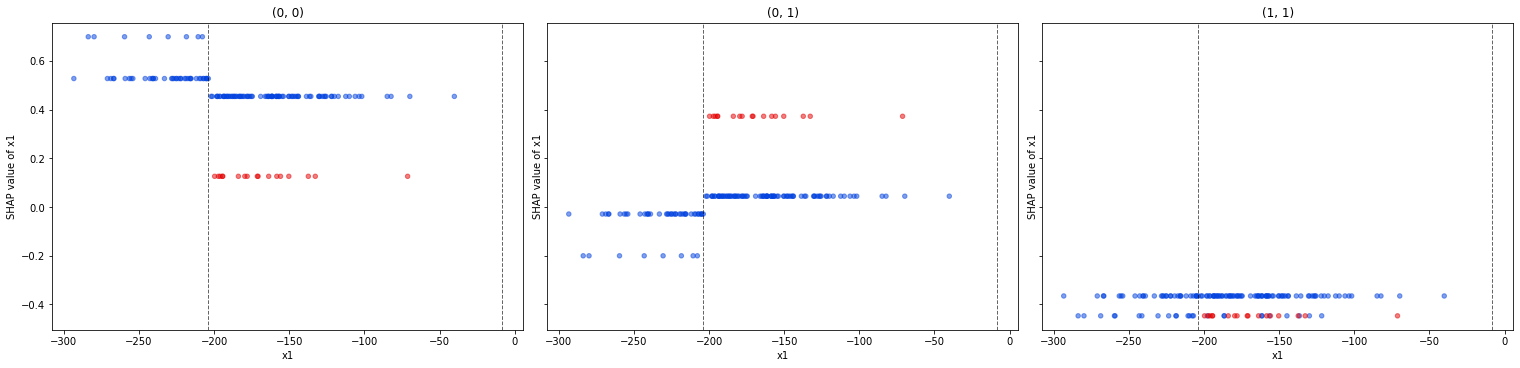

In [18]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.plot_feature_dependence(feature, alpha=0.5)

It's easier to spot when plotting the parents' instances, and highlight the instances in this node.

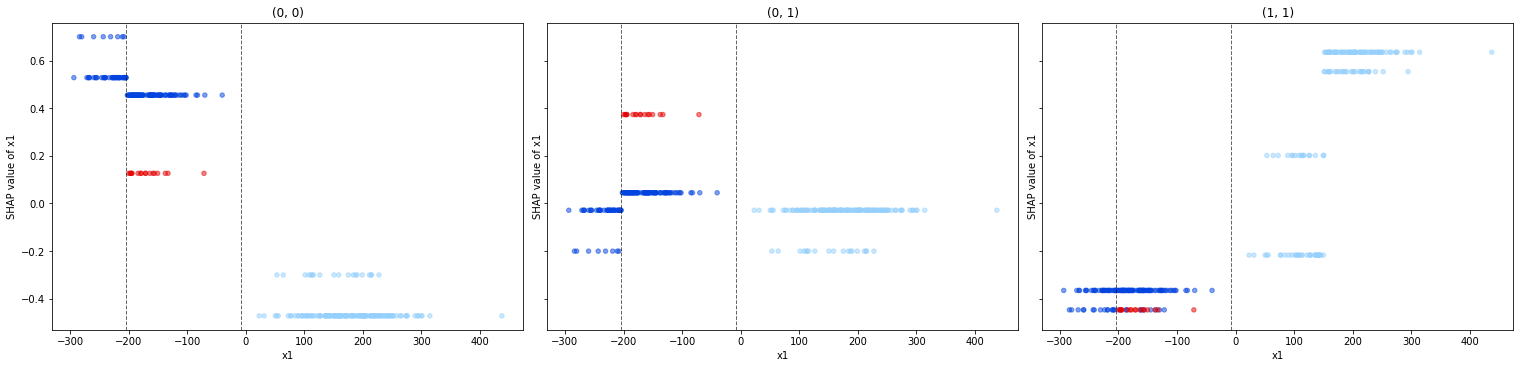

In [19]:
node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

The instances not in the current reference cluster node (lighter color) are those classified $(1,1)$ and $(1,0)$, which are also responsible for the global highs in the $(1,1)$ dependence plot.

101.87170468931079 <= x2
[Lower CF: x2 == 97.5 --> {'(0, 0)': 17}]


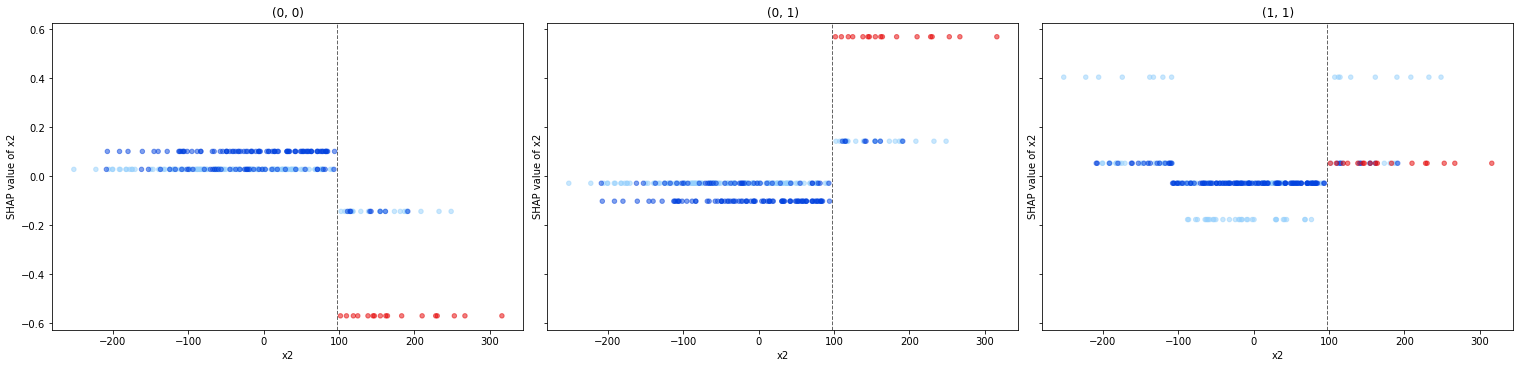

In [20]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

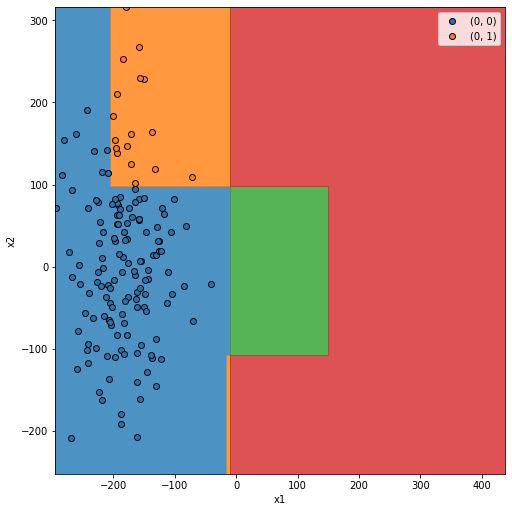

In [21]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim)

### Node RL

The next child node contains only instances classified $(0,1)$, all instances classified $(0,0)$ went into the sibling node. It is also a leaf node, because the distance is zero. This means that the clusters' instances are maximally similar in terms of their SHAP values.

In [22]:
node = node.get_left()
node, node.class_counts, node.distance

(RL,
 (0, 1)    17
 dtype: int64,
 0.0)

Because the group of instances classified $(0,1)$ has not been split, the dependence plots don't contain any additional information. So in this example, there is no explanation more specific than the global explanation.

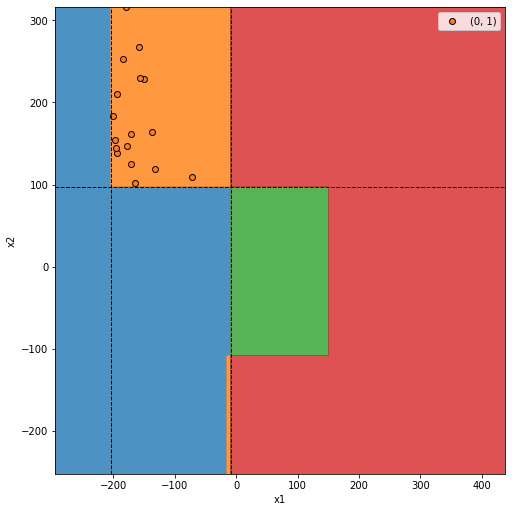

In [23]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Evaluation

In [25]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

#### Global Fidelity

1. -203.8 < x1 <= -8.6 and x2 > 97.5
Number of rules: 1
Number of constraints: 3 (3.0 per rule)
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       283
        True       1.00      1.00      1.00        17

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



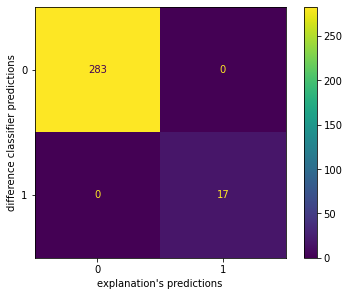

In [24]:
print_rules(rules)
print_complexity(constraints)
node.root.evaluate_rules(*rules)

#### Counterfactual Fidelity Error

In [26]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [27]:
rmse

x1    0.0
x2    0.0
dtype: float64

In [28]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [29]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

#### Complexity

In [29]:
print_complexity([constraint_global])

Number of rules: 1
Number of constraints: 3 (3.0 per rule)


#### Novelty

While the fidelity of the decision rules evaluated on the data set is perfect, it does not capture this manually created outlier. This instance is actually predicted as $(0,1)$, but the decision rule derived from the $(0,1)$ explanation does not capture it.

In [30]:
X_test = np.array([[-15, -110]])

In [32]:
rclf = RuleClassifier(feature_names, rules)
rclf.predict(X_test)

array([False])

## Clustering of Class $(1,0)$ SHAP Values

In [33]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'],
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 276 ms, sys: 5.41 ms, total: 281 ms
Wall time: 298 ms


((0, 0)    133
 (1, 1)    118
 (1, 0)     32
 (0, 1)     17
 dtype: int64,
 2.5922833333333326)

In [34]:
with open(f'ground_truth.{node.diff_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

This time, I will descend the cluster hierarchy until the last node, the contains all instances classified $(1,0)$. It helps to enrich the partial dependence plots with clustering context.

### Node 1 (RL)

I arrive at the left child of the right child of the root node. All other instances are in different nodes. It is a leaf node, because the distance is 0.

In [35]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RL,
 (1, 0)    32
 dtype: int64,
 0.0)

The parent node (R) contains additionally the instances classified $(1,1)$. I will use this as the reference node, to be highlighted in the global dependence plots.

In [36]:
node = node.parent
node.class_counts

(1, 1)    118
(1, 0)     32
dtype: int64

There is a lower and an upper CF for x1:
- Below the lower CF, $(0,0)$ is in a global high, while $(1,0)$ and $(1,1)$ remain in a global low. Only non-highlighted instance are there, that is, those classified $(0,0)$.
- Between the lower and upper CF are instances classified $(1,0)$ (red). This class has a global high here. $(0,0)$ is in a global low, but $(1,1)$ is in mid-range. Clearly, interaction effects determine, whether the SHAP value of x1 increases for $(1,0)$ and at the same time decreases for $(1,1)$, or increases slightly for $(1,0)$ and also increases slightly for $(1,1)$.
- Above the upper CF $(1,1)$ is in a global high, while the others are in a global low.

23.067264476014415 <= x1 <= 149.93548780588142
[Lower CF: x1 == -8.6 --> {'(0, 0)': 32},
 Upper CF: x1 == 150.8 --> {'(1, 1)': 32}]


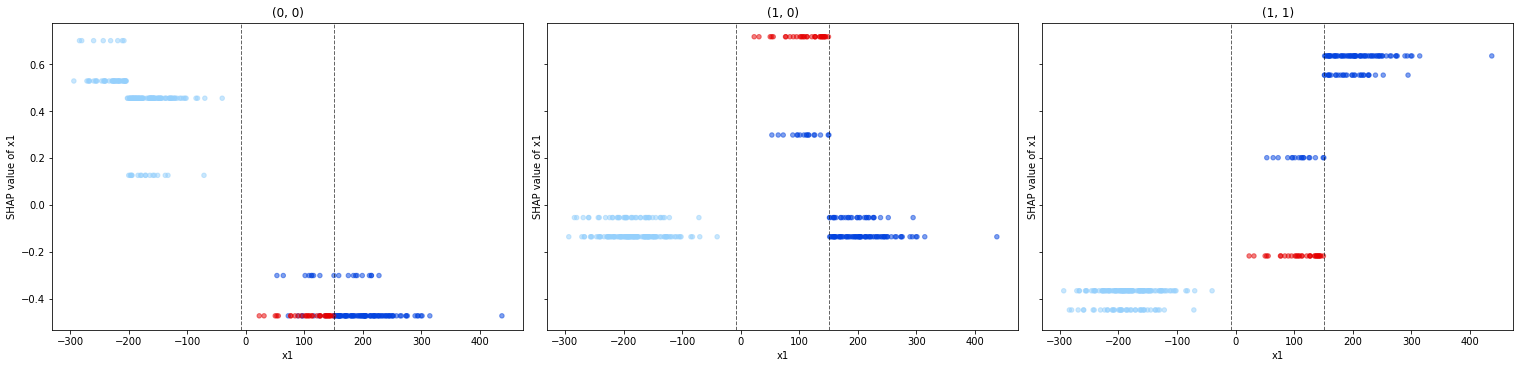

In [37]:
feature = 'x1'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

There is a lower and an upper CF for x2:
- Below the lower CF, $(1,1)$ and $(0,0)$ are in a global high while $(1,0)$ is in a global low. 
- Between the lower and the upper CF, $(1,0)$ and $(0,0)$ are in a global high, while $(1,1)$ is in a global low. Both instances classsified $(1,0)$ and not like this are within this range. Interaction effects with other features determine whether the SHAP value of $(1,0)$ is higher or lesser.
- Above the upper CF, $(1,1)$ is in a global high while the others are in a global low.

-87.58963700149516 <= x2 <= 76.76250825051287
[Lower CF: x2 == -108.2 --> {'(1, 1)': 32},
 Upper CF: x2 == 97.6 --> {'(1, 1)': 32}]


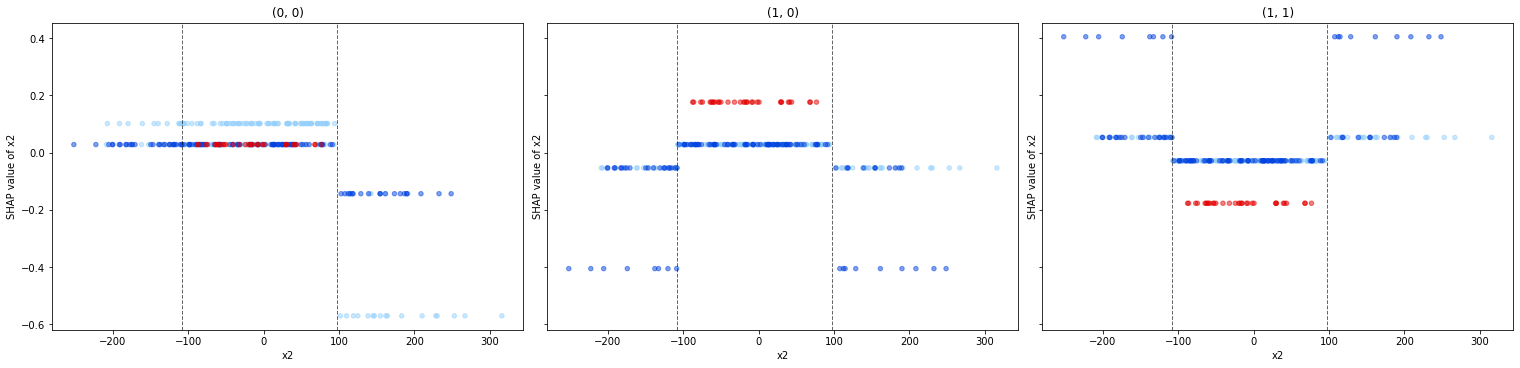

In [38]:
feature = 'x2'
node.describe_feature_differences(feature)
pprint(node.counterfactuals[feature])
node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

-8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       118
        True       1.00      1.00      1.00        32

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



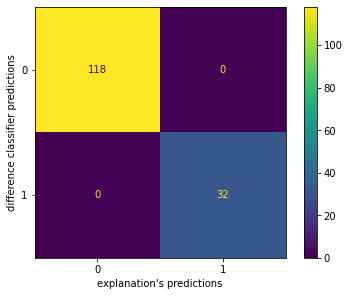

In [39]:
rule, constraint, instance_indices = node.rule_from_counterfactuals()
print(rule)
node.evaluate_rules(rule)

In [40]:
explanations_global = [(rule, constraint, instance_indices)]

A decision rule, derived from the ranges between the CFs achieves perfect accuracy on the data set.

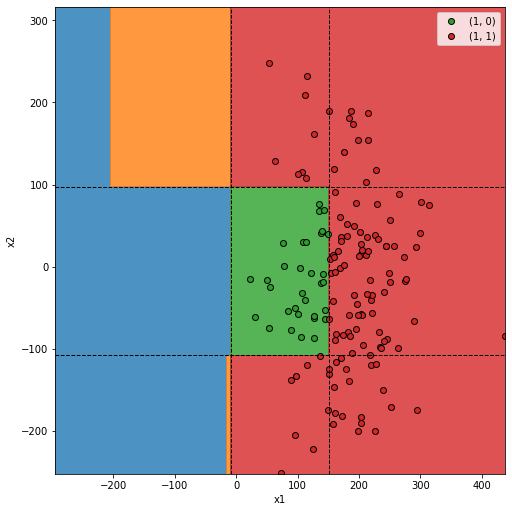

In [41]:
comparer.plot_decision_boundaries(node.data, xlim=xlim, ylim=ylim, show=False)
for cf in node.counterfactuals['x1']:
    plt.axvline(cf.value, linewidth=1, color='black', linestyle='--')
for cf in node.counterfactuals['x2']:
    plt.axhline(cf.value, linewidth=1, color='black', linestyle='--')

### Evaluation

In [48]:
rules, constraints, instance_indices_per_rule = zip(*explanations_global)

#### Global Fidelity

1. -8.6 < x1 <= 150.7 and -108.2 < x2 <= 97.5
Number of rules: 1
Number of constraints: 4 (4.0 per rule)
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       268
        True       1.00      1.00      1.00        32

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



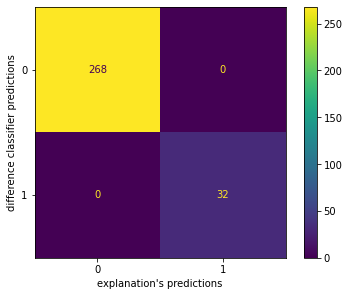

In [49]:
print_rules(rules)
print_complexity(constraints)
node.root.evaluate_rules(*rules)

#### Counterfactual Fidelity Error

In [50]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

In [51]:
rmse

x1    0.0
x2    0.0
dtype: float64

In [52]:
boundary_miss_rate

x1    0.0
x2    0.0
dtype: float64

In [53]:
boundary_add_rate

x1    0.0
x2    0.0
dtype: float64

#### Complexity

In [54]:
print_complexity(constraints)

Number of rules: 1
Number of constraints: 4 (4.0 per rule)


# Summary

## Global Fidelity

Ruleset | Precision | Recall | F1
 --- | --- | --- | ---
01 | 1.0 | 1.0 | 1.0
10 | 1.0 | 1.0 | 1.0

## Counterfactual Fidelity Error

Ruleset | RMSE | boundaries missed | unnecessary boundaries
 --- | --- | --- | ---
01 | <0.1 | 0% | 0%
10 | <0.1 | 0% | 0%

## Complexity

Ruleset | # Rules | # Constraints
 --- | --- | ---
01 | 1 | 3
10 | 1 | 4

Selectiveness: optimal

## Bonus Task

Failed to detect outlier.

## Generation Time

approx. 1s